Import the relevant libraries.



In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
# from scipy import optimize
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# import matplotlib.pyplot as plt
# import tensorflow as tf
# import altair as alt
# from linearmodels.iv import IV2SLS
# from tensorflow.keras import datasets, layers, models
# from tensorflow import keras
# import theano
# import pymc3 as pm
# import arviz as az
# import seaborn as sn


# import covid19pandas as cod
from country_codes import eurostat_dictionary
import eurostat
import matplotlib.pyplot as plt


from warnings import filterwarnings
filterwarnings('ignore')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

## Dealing with data



In this section we work with the API of Eurostat to get data directly into the notebook.

We look at the data for each variable, decide on the shape we want to have for the dataframe and then merge a number of data sets together. For this we will be using pandas. Further, we use the python file `country_codes.py` which should be in the same folder as this notebook.



### Countries



We focus on the following countries when looking at the data. For the Eurostat data this does not matter so much. But if you want to combine Eurostat data with OECD data, this selection can be useful.



In [5]:
EU_countries = ['Belgium', 'Bulgaria', 'Czechia', 'Denmark',
'Germany (until 1990 former territory of the FRG)', 'Germany','Estonia',
'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy',
'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta',
'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania',
'Slovenia', 'Slovakia', 'Finland', 'Sweden', 'United Kingdom',
'Iceland', 'Liechtenstein', 'Norway', 'Switzerland',
'Bosnia and Herzegovina']

### Mortality



The [Eurostat website](https://ec.europa.eu/eurostat/data/database?node_code=hlth_cd_apr) has a browser where you can look for data. Here we are looking for data on mortality. You can click on the link to the data browser to see the [details of the variable](https://ec.europa.eu/eurostat/databrowser/view/hlth_cd_apr/default/table?lang=en). At the top-left of the screen you can see the name of the variable in the line &ldquo;`online data code: HLTH_CD_APR`&rdquo;. The name of this variable we use below in the `get_data_df` method.

So we call this method and collect the information in the dataframe `df`. Then we check what `df` looks like:



In [6]:
df = eurostat.get_data_df('hlth_cd_apr')
df.head()

,freq,mortalit,sex,icd10,unit,geo\TIME_PERIOD,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,A,PRVT,F,A00-A09,NR,AT,7.0,12.0,9.0,6.0,5.0,15.0,10.0,8.0,6.0,13.0
1,A,PRVT,F,A00-A09,NR,BE,25.0,11.0,20.0,26.0,26.0,27.0,45.0,26.0,44.0,39.0
2,A,PRVT,F,A00-A09,NR,BG,5.0,4.0,10.0,11.0,13.0,7.0,4.0,3.0,4.0,5.0
3,A,PRVT,F,A00-A09,NR,CH,14.0,14.0,9.0,9.0,5.0,13.0,13.0,11.0,14.0,10.0
4,A,PRVT,F,A00-A09,NR,CY,6.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0


So we have a number of columns with abbreviations in them and then we have data for the years 2011-2017. Use the website of the variable to figure out what the abbreviations mean. To illustrate, the column `mortalit` gives three measures of mortality:



In [7]:
df.mortalit.unique()

array(['PRVT', 'TOTAL', 'TRT'], dtype=object)

We will be interested in preventable &rsquo;PRVT&rsquo; and treatable &rsquo;TRT&rsquo; mortality.

First, let&rsquo;s change the country column &rsquo;geo\time&rsquo; and use country names instead of abbreviations. We need to &ldquo;escape&rdquo; the &rsquo;\\&rsquo; symbol to make sure pandas reads &rsquo;\\&rsquo; literally (not as a symbol). That is why we have &rsquo;\\\\&rsquo; in the code below. We use the `eurostat_dictionary` to turn the country abbreviations into country names.

Note that to change the column name we use `.rename`; to change values in a row, we use `.replace`. The replacements are provided using a python dictionary: `{'old_name':'new_name'}`.

If you are wondering why we use `inplace=True`, just run the code block without this to see the difference.



In [8]:
df.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)
df['country'] = df['geo'].replace(eurostat_dictionary)
df.head()

,freq,mortalit,sex,icd10,unit,geo,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,country
0,A,PRVT,F,A00-A09,NR,AT,7.0,12.0,9.0,6.0,5.0,15.0,10.0,8.0,6.0,13.0,Austria
1,A,PRVT,F,A00-A09,NR,BE,25.0,11.0,20.0,26.0,26.0,27.0,45.0,26.0,44.0,39.0,Belgium
2,A,PRVT,F,A00-A09,NR,BG,5.0,4.0,10.0,11.0,13.0,7.0,4.0,3.0,4.0,5.0,Bulgaria
3,A,PRVT,F,A00-A09,NR,CH,14.0,14.0,9.0,9.0,5.0,13.0,13.0,11.0,14.0,10.0,Switzerland
4,A,PRVT,F,A00-A09,NR,CY,6.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0,Cyprus


Now we will select the values that we are interested in: only EU countries, both males and females, both preventable and treatable mortality, unit of measurement rate &rsquo;RT&rsquo; (not number &rsquo;NR&rsquo;) and all diseases (e.g. not the subset &ldquo; [A00-A09] Intestinal infectious diseases&rdquo;).

For selection, we can use `==` or `.isin()`. With numbers we can also use smaller/greater than `<,>` etc.

After this selection, we can drop some columns to make the dataframe a bit easier to handle.



In [9]:
df = df[df.country.isin(EU_countries) & (df.sex.isin(["M","F"]) ) & (df.mortalit.isin(["PRVT","TRT"])) \
        & (df.unit == "RT") & (df.icd10 == "TOTAL")]
df.drop(["unit","icd10","geo"],axis=1,inplace=True)
df.head()

,freq,mortalit,sex,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,country
6300,A,PRVT,F,95.29,96.16,93.22,93.95,97.52,96.39,92.94,93.14,94.81,99.09,Austria
6301,A,PRVT,F,101.35,99.97,100.34,95.40,99.71,94.13,93.42,92.83,92.39,113.63,Belgium
6302,A,PRVT,F,119.32,126.17,119.29,129.04,128.32,120.14,121.87,119.05,120.05,177.73,Bulgaria
6303,A,PRVT,F,73.75,74.02,73.85,72.70,69.37,68.91,68.45,71.15,67.12,72.59,Switzerland
6304,A,PRVT,F,57.31,49.38,47.75,54.65,55.67,49.98,46.69,50.87,49.03,54.90,Cyprus


In [10]:
df = pd.melt(df,id_vars=['country','sex','mortalit'],
                        value_vars= df.columns[2:-1],
                        var_name='year',
                        value_name='rate')
df.head()

,country,sex,mortalit,year,rate
0,Austria,F,PRVT,2011,95.29
1,Belgium,F,PRVT,2011,101.35
2,Bulgaria,F,PRVT,2011,119.32
3,Switzerland,F,PRVT,2011,73.75
4,Cyprus,F,PRVT,2011,57.31


Instead of one column `rate` we want to have two columns (i.e. two variables); one corresponds to PRVT, the other to TRT. For this we use [unstack](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html). We put the identifying columns in an order such that the last column refers to `mortalit` which contains the two values PRVT and TRT. These columns become the index of the dataframe. Then we unstack the dataframe on the last column of the index, which is the default value of `unstack()`. This pivots the column `mortalit` into two separate columns PRVT and TRT.



In [11]:
df.set_index(['country','year','sex','mortalit'],inplace=True)
df = df.unstack()
df.head()

rate       
mortalit            PRVT    TRT
country year sex               
Austria 2011 F     95.29  67.41
             M    248.50  96.86
        2012 F     96.16  69.72
             M    252.28  91.45
        2013 F     93.22  66.84

Finally, we reset the index (such that it no longer features the hierarchy &#x2013;with &rsquo;rate&rsquo; and &rsquo;mortalit&rsquo;&#x2013; shown above) and rename the columns to make them easier to read/understand.



In [12]:
df.reset_index(inplace=True)
df.columns = [' '.join(col).strip() for col in df.columns.values]
df.rename({'rate PRVT':'Preventable mortality', 'rate TRT':'Treatable mortality'},inplace=True,axis=1)
df.head()

,country,year,sex,Preventable mortality,Treatable mortality
0,Austria,2011,F,95.29,67.41
1,Austria,2011,M,248.50,96.86
2,Austria,2012,F,96.16,69.72
3,Austria,2012,M,252.28,91.45
4,Austria,2013,F,93.22,66.84


Now we consider a number of other variables. There you can practice the steps above to get these dataframes into the right shape. Finally, we merge each dataframe with the one previously created.



### GDP per capita



Go to this [page](https://ec.europa.eu/eurostat/data/database?node_code=nama_10_pc) to find the variable name for &ldquo;Main GDP aggregates per capita&rdquo;; fill in the &ldquo;dots&rdquo; in the following code:



In [26]:
def download_oecd_data(data_code): # 'nama_10_pc'
    df_n = eurostat.get_data_df(data_code)
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    # drop columns that contain all nan values
    # Dropping columns with all NaN values
    df_n.dropna(axis=1, how='all', inplace=True)
    df_n = pd.melt(df_n,id_vars=['country','unit'],
                        value_vars= df_n.columns[4:-1],
                        var_name='year',
                        value_name='gdp')

    # merged_df = df.merge(df_n, on=['country', 'year'], how='left') 
    return df_n

df_n = download_oecd_data('nama_10_pc')
df_n

,country,unit,year,gdp
0,Albania,CLV10_EUR_HAB,1975,NaN
1,Austria,CLV10_EUR_HAB,1975,NaN
2,Belgium,CLV10_EUR_HAB,1975,NaN
3,Bulgaria,CLV10_EUR_HAB,1975,NaN
4,Switzerland,CLV10_EUR_HAB,1975,NaN
...,...,...,...,...
166603,Sweden,PC_EU27_2020_HAB_MPPS_CP,2022,112.2
166604,Slovenia,PC_EU27_2020_HAB_MPPS_CP,2022,89.5
166605,Slovakia,PC_EU27_2020_HAB_MPPS_CP,2022,74.2
166606,Turkey,PC_EU27_2020_HAB_MPPS_CP,2022,67.5


### Income quantiles



Use [this page](https://ec.europa.eu/eurostat/databrowser/view/icw_res_02/default/table?lang=en) to get the variable name for &ldquo;Mean and median economic resources of households by income, consumption and wealth quantiles - experimental statistics&rdquo;.



We drop the year 2010 as it does not lie in the period for which we have the other data that we download.



In [27]:
def get_mean_median_income():
    df_n = eurostat.get_data_df('icw_res_02') #icw_res_02
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

    df_n = df_n[(df_n.indic_il=='INC_DISP')&(df_n.statinfo=='AVG')&(df_n.quant_inc.isin(['QU1', 'QU2', 'QU3', 'QU4', 'QU5']))&(df_n.quant_expn=='TOTAL')&(df_n.quant_wlth=='TOTAL')]

    df_n.drop(['unit','quant_expn','quant_wlth','indic_il','statinfo', '2010'],axis=1,inplace=True)
    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)

    df_n.drop(['geo'],axis=1,inplace=True)

    df_n = pd.melt(df_n,id_vars=['country','quant_inc'],
                            value_vars= df_n.columns[1:-1],
                            var_name='year',
                            value_name='mean/median income')

    df_n.set_index(['country', 'year', 'quant_inc'], inplace=True)

    df_n = df_n[df_n.index.duplicated(keep='last')] # removing duplicate indices

    df_n.index.unique()

    df_n = df_n.unstack(level='quant_inc')
    return df_n

df_n = get_mean_median_income()
df_n


mean/median income                                     
quant_inc                          QU1      QU2      QU3      QU4       QU5
country        year                                                        
Austria        2015            16542.1  27955.8  36687.8  48214.5   74519.8
               2020            17597.6  32409.5  41893.2  52793.7   83297.4
Belgium        2015            15834.1  23310.6  33248.2  44849.9   68233.2
               2020            18600.4  27357.2  39019.0  52166.4   76766.2
Bulgaria       2015             1847.7   3270.1   5115.9   7451.6   14354.6
               2020             2413.2   4260.6   7198.8  10950.6   22804.2
Cyprus         2015            11467.4  18180.6  25357.4  35763.9   60673.0
               2020                NaN      NaN      NaN      NaN       NaN
Czechia        2015             5855.1   9334.9  12419.9  16699.2   26053.4
               2020             7621.9  12481.4  17278.8  22689.7   34311.1
Germany        2015             9952.4  20975.5  29266.7  38707.9   64555.2
               2020            12472.2  25250.4  34287.9  44182.9   72677.9
Denmark        2015            16748.4  29074.2  39407.5  52636.6   87674.0
               2020            18284.5  31348.0  43825.1  58590.0   97349.3
Estonia        2015             4233.3   7538.9  13294.9  19001.3   32143.5
               2020             5707.0  10851.5  18272.9  25955.9   42821.2
Greece         2015             4999.1   9838.0  12724.9  17132.8   30127.6
               2020             6107.4  11060.5  15235.9  19901.8   33330.4
Spain          2015             8959.4  16158.6  23198.7  31863.7   54359.7
               2020             9830.3  19195.6  27237.6  36968.4   59568.6
Finland        2015            15468.8  25529.5  35562.7  45565.7   72075.0
               2020                NaN      NaN      NaN      NaN       NaN
France         2015            18570.2  26617.5  33734.1  44273.2   75513.0
               2020                NaN      NaN      NaN      NaN       NaN
Croatia        2015             3333.2   6707.4   9936.8  13733.3   21342.7
               2020             4460.5   9218.4  14107.7  19522.7   29455.0
Hungary        2015             3657.7   5866.3   7641.1  10043.4   16038.2
               2020             4653.0   7770.8  10412.5  14021.3   21701.2
Ireland        2015            16284.8  27143.3  40885.3  55274.0   84507.0
               2020                NaN      NaN      NaN      NaN       NaN
Lithuania      2015             2678.2   5395.5   8944.2  13645.4   26602.9
               2020                NaN      NaN      NaN      NaN       NaN
Luxembourg     2015            26230.1  47129.0  56621.7  75137.2  127617.7
               2020            34354.0  50762.8  66659.0  86258.3  134875.3
Latvia         2015             2903.8   5817.0   9990.3  14587.3   26319.6
               2020             3814.0   8066.5  13384.4  20028.9   34520.6
Malta          2015            10491.7  15485.1  22706.8  31267.9   51661.8
               2020                NaN      NaN      NaN      NaN       NaN
Netherlands    2015            15503.8  24213.9  33979.6  44922.9   72170.4
               2020            16320.7  27013.7  37923.2  53571.5   89576.2
Poland         2015             4614.5   8014.8  10857.3  14465.7   22984.3
               2020             6427.0  11086.1  15429.9  20213.6   30231.7
Portugal       2015             6208.9  10708.5  15079.3  20649.4   37729.5
               2020                NaN      NaN      NaN      NaN       NaN
Romania        2015             1681.5   3048.3   4116.6   5764.5    9844.5
               2020             2483.3   5438.3   7764.3  11155.5   18997.8
Sweden         2015            14078.1  24141.6  37051.4  48388.8   71973.8
               2020                NaN      NaN      NaN      NaN       NaN
Slovenia       2015             7877.5  14305.4  20553.2  26351.4   39314.2
               2020             8932.3  16407.6  22457.2  30082.9   

In [28]:
merged_df = df.merge(df_n.reset_index(), on=['country', 'year'], how='left')
merged_df.head()

,country,year,sex,Preventable mortality,Treatable mortality,"(mean/median income, QU1)","(mean/median income, QU2)","(mean/median income, QU3)","(mean/median income, QU4)","(mean/median income, QU5)"
0,Austria,2011,F,95.29,67.41,NaN,NaN,NaN,NaN,NaN
1,Austria,2011,M,248.50,96.86,NaN,NaN,NaN,NaN,NaN
2,Austria,2012,F,96.16,69.72,NaN,NaN,NaN,NaN,NaN
3,Austria,2012,M,252.28,91.45,NaN,NaN,NaN,NaN,NaN
4,Austria,2013,F,93.22,66.84,NaN,NaN,NaN,NaN,NaN


In [29]:
df_n = eurostat.get_data_df('lfsa_urgan') 
df_n.head()

,freq,unit,sex,age,citizen,geo\TIME_PERIOD,1995,1996,1997,1998,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,A,PC,F,Y15-19,EU27_2020_FOR,AT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A,PC,F,Y15-19,EU27_2020_FOR,BE,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A,PC,F,Y15-19,EU27_2020_FOR,BG,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A,PC,F,Y15-19,EU27_2020_FOR,CH,NaN,NaN,NaN,NaN,...,15.7,18.3,19.5,15.0,17.7,16.6,9.8,13.3,13.3,17.1
4,A,PC,F,Y15-19,EU27_2020_FOR,CY,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_n = eurostat.get_data_df('yth_demo_080')
df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

df_n['country'] = df_n['geo'].replace(eurostat_dictionary)

df_n.drop(['geo'],axis=1,inplace=True)
df_n.tail()

,freq,agedef,c_birth,unit,sex,age,2008,2009,2010,2011,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,country
250767,A,REACH,ZW,PC,T,Y25-29,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,North Macedonia
250768,A,REACH,ZW,PC,T,Y25-29,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Netherlands
250769,A,REACH,ZW,PC,T,Y25-29,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Norway
250770,A,REACH,ZW,PC,T,Y25-29,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,Sweden
250771,A,REACH,ZW,PC,T,Y25-29,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Slovakia


2008     17160.0
2009     16615.0
2010     21745.0
2011     28235.0
2012     24850.0
2013     31125.0
2014     33815.0
2015    107255.0
2016    148155.0
2017     89880.0
2018     58105.0
2019     50280.0
2020     24525.0
2021     19310.0
2022     17460.0
dtype: float64


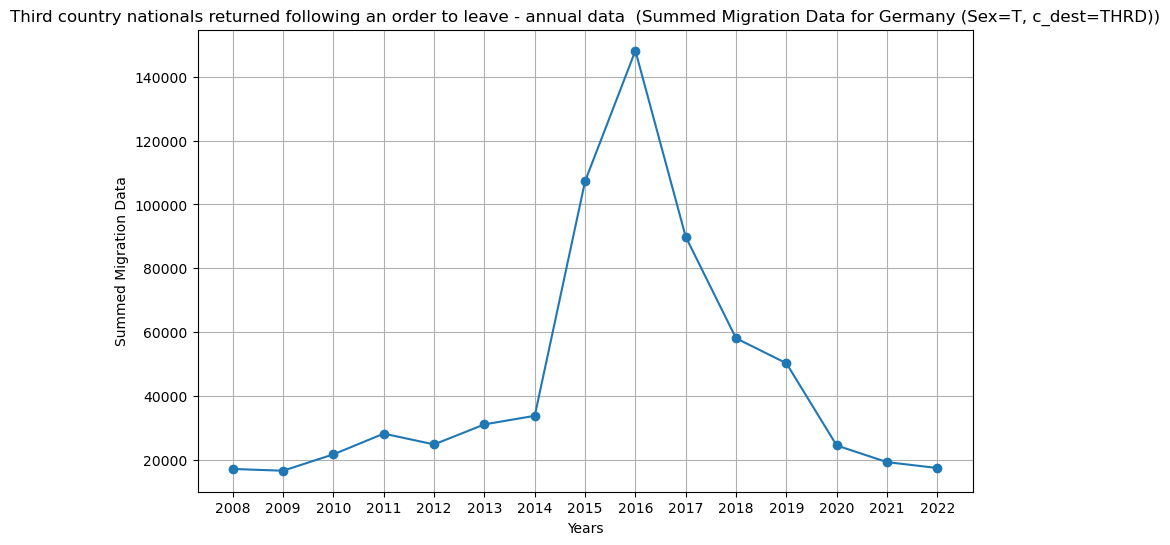

In [32]:

def get_3rd_country_nationals_returned_annualty(country):
    '''Third country nationals returned following an order to leave - annual data (rounded)'''
    df_n = eurostat.get_data_df('migr_eirtn')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)

    df_n = df_n[df_n['age']== 'TOTAL']

    df_n.set_index(['country','freq', 'c_dest', 'age', 'sex'], inplace=True)

    df_n.drop(['geo'],axis=1,inplace=True)

    df_n_reset = df_n.reset_index()

    # Assuming 'year_columns' represents the columns that contain years
    year_columns = [col for col in df_n_reset.columns if col not in ['country', 'freq', 'c_dest', 'age', 'sex', 'citizen', 'unit']]

    # Plotting for a specific country (e.g., 'Germany') and all the years

    country_data = df_n_reset[df_n_reset['country'] == country]
    country_data = country_data[country_data['sex'] == 'T']
    country_data = country_data[country_data['c_dest'] == 'THRD']


    # Selecting columns representing years
    year_columns = [col for col in country_data.columns if col not in ['country', 'freq', 'c_dest', 'age', 'sex', 'citizen', 'unit']]

    # Summing over rows for each year
    summed_data = country_data[year_columns].sum()
    print(summed_data)

    # Plotting the summed data
    plt.figure(figsize=(10, 6))
    plt.plot(summed_data.index, summed_data.values, marker='o', linestyle='-')
    plt.xlabel('Years')
    plt.ylabel('Summed Migration Data')
    plt.title(f'Third country nationals returned following an order to leave - annual data  (Summed Migration Data for {country} (Sex=T, c_dest=THRD))')
    plt.grid(True)
    plt.show()

    return summed_data

df_n = get_3rd_country_nationals_returned_annualty('Germany')



2008    30305.0
2009    28875.0
2010    26430.0
2011    26705.0
2012    30245.0
2013    26540.0
2014    26065.0
2015    24360.0
2016    21830.0
2017    25405.0
2018    30870.0
2019    31240.0
2020    13860.0
2021    13745.0
2022    18815.0
dtype: float64


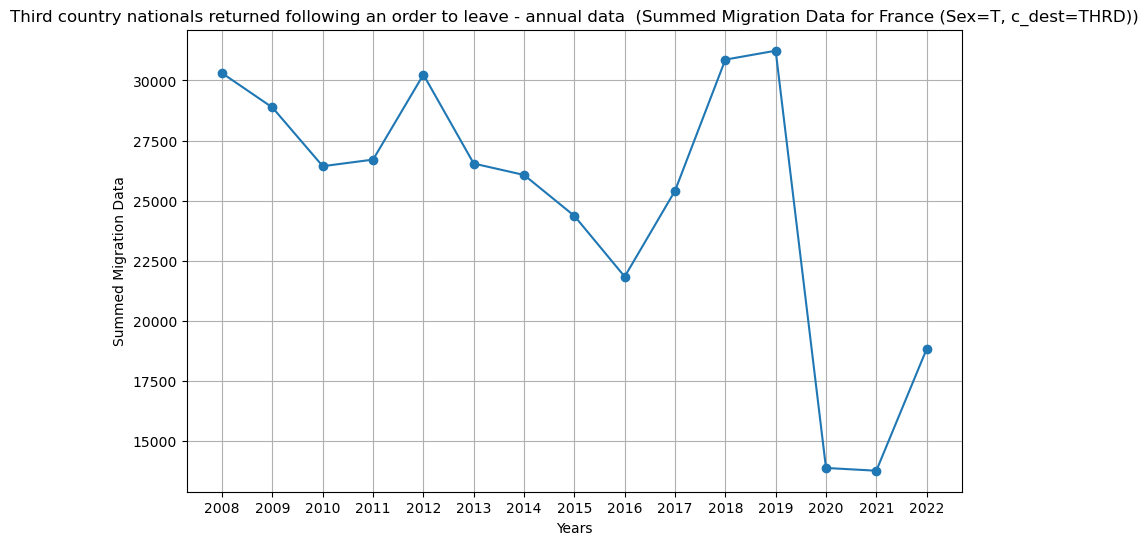

In [31]:

df_n = get_percentage_youth_at_home('France')

['Y16-19' 'Y16-24' 'Y16-29' 'Y18-24' 'Y18-34' 'Y20-24' 'Y20-29' 'Y25-29'
 'Y25-34']


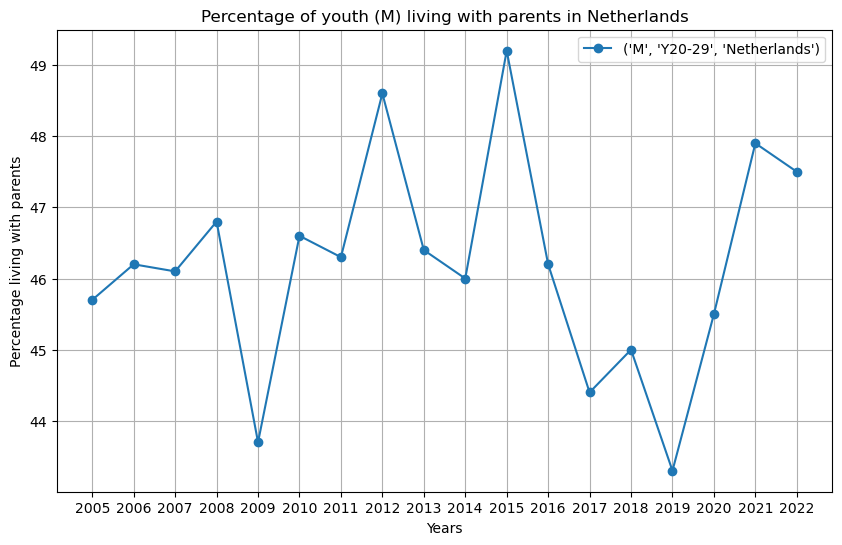

['Y16-19' 'Y16-24' 'Y16-29' 'Y18-24' 'Y18-34' 'Y20-24' 'Y20-29' 'Y25-29'
 'Y25-34']


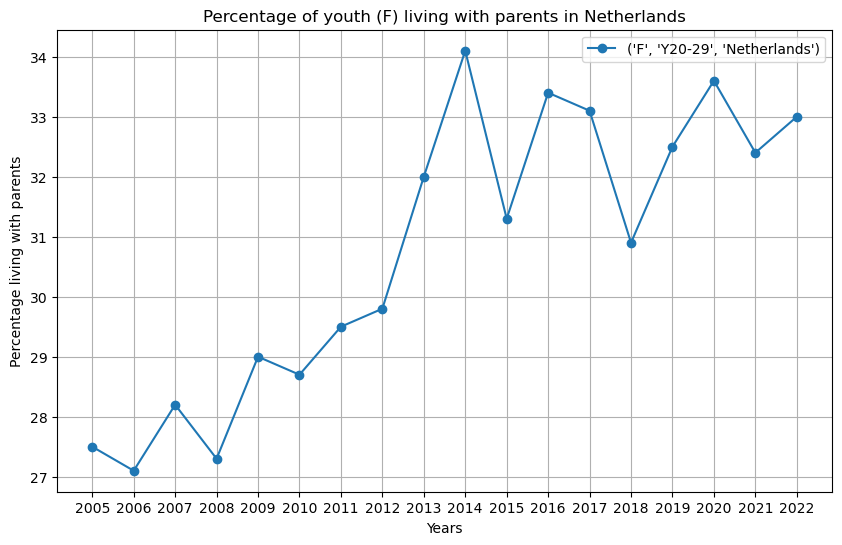

['Y16-19' 'Y16-24' 'Y16-29' 'Y18-24' 'Y18-34' 'Y20-24' 'Y20-29' 'Y25-29'
 'Y25-34']


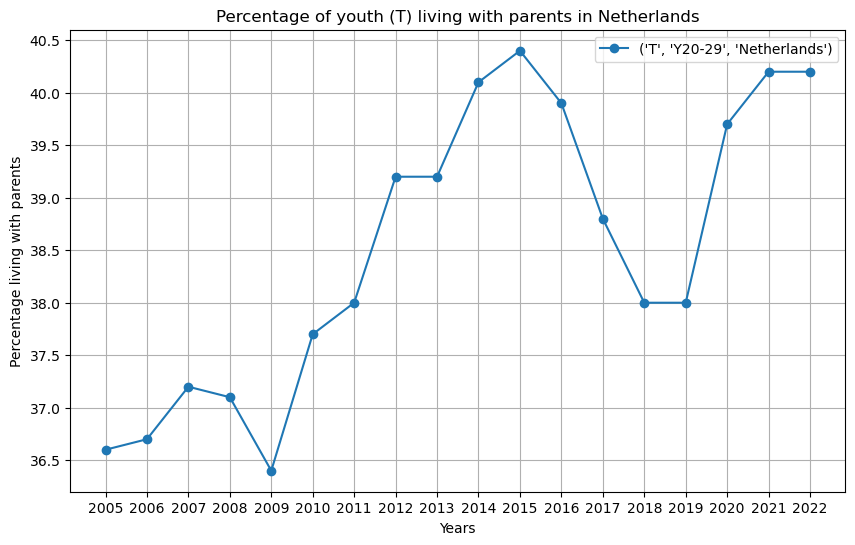

In [55]:

def youth_at_home(COUNTRY, SEX, AGE):
    df_n = eurostat.get_data_df('ilc_lvps08') # YOUNG PEOPLE LIVING AT HOME
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

    # Frequency of heavy episodic drinking by sex, age and educational attainment level

    # df_n.drop(['unit','quant_expn','quant_wlth','indic_il','statinfo', '2010'],axis=1,inplace=True)

    df_n.drop(['unit', 'freq'],axis=1,inplace=True)
    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)

    df_n.drop(['geo'],axis=1,inplace=True)
    print(df_n['age'].unique())

    df_n = df_n[df_n['country'] == COUNTRY]
    df_n = df_n[df_n['sex'] == SEX]

    

    df_n = df_n[df_n['age'] == AGE]


    df_n.drop(['2003', '2004'],axis=1, inplace=True) # 'sex', 'age', 'country', 

    df_n.set_index(['sex', 'age', 'country'], inplace=True)
    

    df_n = df_n.tail(3)
    df_n = df_n.T

    # Assuming df_n is your modified DataFrame
    plt.figure(figsize=(10, 6))

    for column in df_n.columns:

        plt.plot(df_n.index, df_n[column], marker='o', linestyle='-', label=column)

    plt.xlabel('Years')
    plt.ylabel('Percentage living with parents')
    plt.title(f'Percentage of youth ({SEX}) living with parents in {COUNTRY}')
    plt.legend()  # Add a legend to differentiate the columns
    plt.grid(True)
    plt.show()

    return df_n

df_n = youth_at_home('Netherlands', 'M', 'Y20-29')
df_n = youth_at_home('Netherlands', 'F', 'Y20-29')
df_n = youth_at_home('Netherlands', 'T', 'Y20-29')

 

MultiIndex([('T', 'Y16-19', 'Netherlands'),
            ('T', 'Y16-24', 'Netherlands'),
            ('T', 'Y16-29', 'Netherlands'),
            ('T', 'Y18-24', 'Netherlands'),
            ('T', 'Y18-34', 'Netherlands'),
            ('T', 'Y20-24', 'Netherlands'),
            ('T', 'Y20-29', 'Netherlands'),
            ('T', 'Y25-29', 'Netherlands'),
            ('T', 'Y25-34', 'Netherlands')],
           names=['sex', 'age', 'country'])


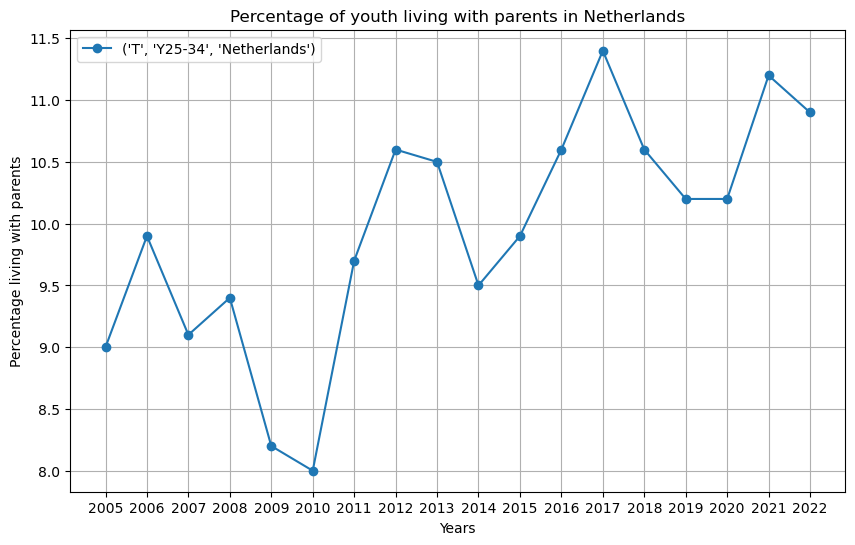

In [36]:
df_n = youth_at_home('Netherlands')

MultiIndex([('T', 'Y16-19', 'France'),
            ('T', 'Y16-24', 'France'),
            ('T', 'Y16-29', 'France'),
            ('T', 'Y18-24', 'France'),
            ('T', 'Y18-34', 'France'),
            ('T', 'Y20-24', 'France'),
            ('T', 'Y20-29', 'France'),
            ('T', 'Y25-29', 'France'),
            ('T', 'Y25-34', 'France')],
           names=['sex', 'age', 'country'])


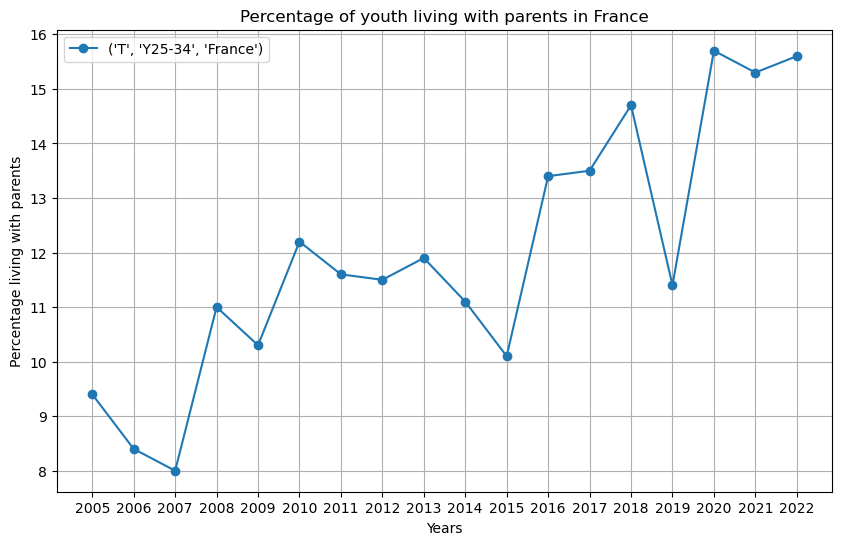

In [37]:
df_n = youth_at_home('France')

     sex     age  1999  2000  2001  2002  2003  2004  2005  2006  ...  2014  \
0      F  Y15-29   1.3   1.0   1.0   NaN   1.1   1.8   1.2   1.1  ...   1.5   
1      F  Y15-29   NaN   NaN   NaN   NaN   NaN   2.6   2.0   NaN  ...   2.3   
2      F  Y15-29   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
3      F  Y15-29   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
4      F  Y15-29   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   3.3   
...   ..     ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1507   T  Y15-29   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   2.5   
1508   T  Y15-29   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   5.8   
1509   T  Y15-29   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   3.3   
1510   T  Y15-29   NaN   NaN   NaN   NaN   NaN   NaN   2.4   NaN  ...   5.1   
1511   T  Y15-29   NaN   NaN   NaN   NaN   NaN   NaN   2.4   NaN  ...   5.1   

      2015  2016  2017  2018  2019  2020  2021  202

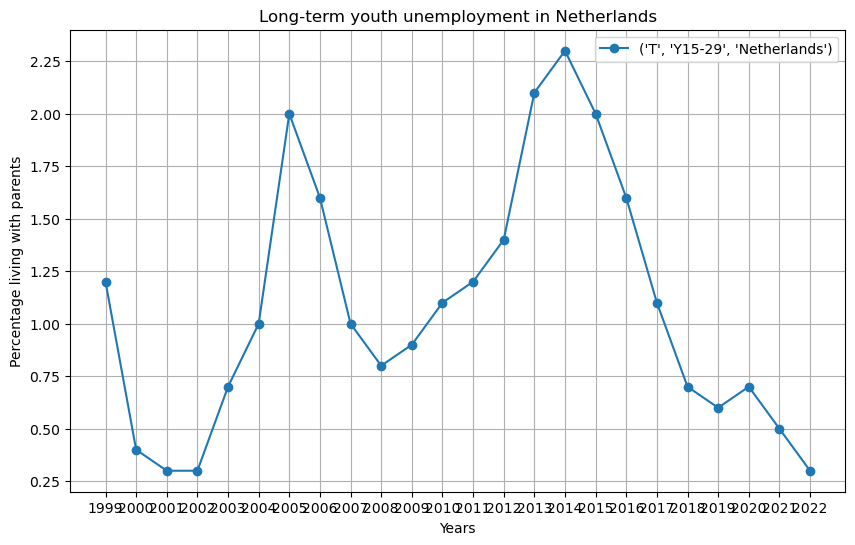

In [45]:

def long_term_youth_unemployment(COUNTRY, SEX):
    df_n = eurostat.get_data_df('yth_empl_130') # Long-term youth unemployment
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)


    df_n.drop(['unit', 'freq'],axis=1,inplace=True)
    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)

    df_n.drop(['geo'],axis=1,inplace=True)
    print(df_n)

    

    df_n = df_n[df_n['country'] == COUNTRY]
    df_n = df_n[df_n['sex'] == SEX]

    df_n.set_index(['sex', 'age', 'country'], inplace=True)
    
    # df_n = df_n.tail(1)
    df_n = df_n.T

    # Assuming df_n is your modified DataFrame
    plt.figure(figsize=(10, 6))

    for column in df_n.columns:
        plt.plot(df_n.index, df_n[column], marker='o', linestyle='-', label=column)

    plt.xlabel('Years')
    plt.ylabel('Percentage living with parents')
    plt.title(f'Long-term youth unemployment in {COUNTRY}')
    plt.legend()  # Add a legend to differentiate the columns
    plt.grid(True)
    plt.show()

    return df_n

df_n = long_term_youth_unemployment('Netherlands', 'T')

#### https://www.rtlnieuws.nl/nieuws/nederland/artikel/5406259/minder-studenten-wonen-op-kamers-bij-ouders-thuis-basisbeurs

"Het totale aantal uitwonende studenten is wel toegenomen, maar dat komt enkel en alleen door een toename van het aantal buitenlandse studenten. Een op de zes studenten komt uit een ander land. In het collegejaar 2015/2016 was minder dan 10 procent van buitenlandse herkomst."


#### https://www.cbs.nl/nl-nl/longread/statistische-trends/2023/de-groeiende-groep-jongvolwassen-thuiswonenden/3-data-en-methode

             0
2012       0.0
2013  180083.0
2014  184595.0
2015  306752.0
2016  318933.0
2017  342398.0
2018  375148.0
2019  410028.0
2020  451382.0
2021  426830.0


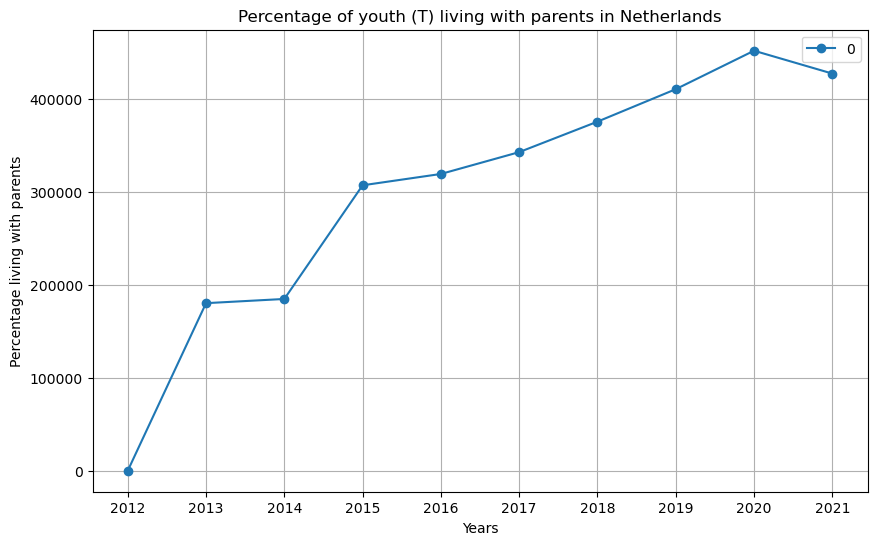

In [75]:
 # Mobile students from abroad enrolled by education level, sex and country of origin



def mobile_students_from_abroad(COUNTRY, SEX):
    df_n = eurostat.get_data_df('educ_uoe_mobs02') # YOUNG PEOPLE LIVING AT HOME
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

    df_n.drop(['unit', 'freq'],axis=1,inplace=True)
    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)

    df_n.drop(['geo'],axis=1,inplace=True)


    df_n = df_n[df_n['country'] == COUNTRY]
    df_n = df_n[df_n['sex'] == SEX]

    # df_n = df_n[df_n['isced11'] == 'ED6' or  df_n['isced11'] == 'ED7']
    df_n = df_n[(df_n['isced11'] == 'ED6') | (df_n['isced11'] == 'ED7')]

    
    df_n.set_index(['sex', 'country', 'partner', 'isced11'], inplace=True)
    
    # sum over all rows
    df_n = df_n.sum()
    
    
    # df_n = df_n.T


    df_n = pd.DataFrame(df_n)
    print(df_n)
    # # Assuming df_n is your modified DataFrame
    plt.figure(figsize=(10, 6))

    for column in df_n.columns:
        plt.plot(df_n.index, df_n[column], marker='o', linestyle='-', label=column)

    plt.xlabel('Years')
    plt.ylabel('Percentage living with parents')
    plt.title(f'Percentage of youth ({SEX}) living with parents in {COUNTRY}')
    plt.legend()  # Add a legend to differentiate the columns
    plt.grid(True)
    plt.show()

    return df_n

df_n = mobile_students_from_abroad('Netherlands', 'T')



 

##  Formulating the causal model
Suppose that policy X was introduced in year XXXX. To measure its effect, the outcome variable is the XXXX the following year. 

POSSIBLE VARIABLES;
1. Percentage of foreign students 
2. Rent prices (average)
3. ...

### The importance of time

1) Activity prior to the treatment (causes the treatment)
2) Activity after the treatment (is the outcome of applying treatment)


In [43]:
causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
U[label="Unobserved Confounders"]; 
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends; signup_month->pre_spends;
signup_month->treatment;
U->treatment; U->pre_spends; U->post_spends;
}"""

# Post-process the data based on the graph and the month of the treatment (signup)
df_i_signupmonth = df[df.signup_month.isin([0,i])].groupby(["user_id", "signup_month", "treatment"]).apply(
    lambda x: pd.Series({'pre_spends': np.sum(np.where(x.month < i, x.spend,0))/np.sum(np.where(x.month<i, 1,0)),
                        'post_spends': np.sum(np.where(x.month > i, x.spend,0))/np.sum(np.where(x.month>i, 1,0)) })
).reset_index()
# print(df_i_signupmonth)
model = dowhy.CausalModel(data=df_i_signupmonth,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="post_spends")
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

NameError: name 'dowhy' is not defined